# **Introduction**

Predictive text modelling is a critical application in natural language processing, facilitating functionalities from autocorrect and autocomplete systems to more complex dialogue generation. In order to solve the two-word/letter autocompletion task, this project will use the Long Short-Term Memory (LSTM) Network to build a language model, trained with modern English novels from the Gutenberg project. This section will elaborate on the history of LSTM and the reason of choosing it for these tasks.


The Recurrent Neural Network (RNN) are a class of neural networks designed to handle sequence prediction problems by processing sequential data one element at a time while maintaining a memory that captures information about previous elements. The basic RNN architecture involves a loop that allow information to persist across time steps, essentially enablling it to make decisions based on both the current input and the received historical context (Elman, 1990). However, RNNs often suffer from vanishing and exploding gradient problems, which impede learning in long sequences (Bengio et al., 1994).


To mitigate the limitations of traditional RNN, LSTM introduce a more complex architecture with a memory cell and three regulatory gates: input, output, and forget gates (Hochreiter & Schmidhuber, 1997). These components work together to regulate the flow of the information, allowing the network to retain or discard information over long periods, thus, addressing the vanishing gradient problem. This capability makes LSTM particularly effective for tasks requiring the model to remember information over extended sequence lengths.

Gated Recurrent Unit (GRU), proposed by Cho et al. (2014), simplifies the LSTM architecture by combining the input and forget gate into a single "update gate" and merging the cell state and hidden state. This reduction in complexity often leads to faster training times without significantly compromising the performance of many tasks

In predictive text applications, both LSTM and GRU demonstrate significant improvements over basic RNN due to their ability to capture longer dependencies. The choice between LSTM and GRU may depend on the specific characteristics of the task and dataset. In this certain circumstance, LSTMs might be preferable for more complex datasets with longer dependencies(Jozefowicz et al., 2015), thus we chose the LSTM to constract the language model.


# **The implementation procedure**

In the first section, we will load all the packages and corpus that is required in training and testing amoung all the models.

In [ ]:
!pip install -U nltk>=3.7.0

import nltk
nltk.download("punkt")
nltk.download("gutenberg")
from nltk.corpus import gutenberg
from nltk.lm import Vocabulary
from nltk.util import pad_sequence, ngrams
from nltk.lm.preprocessing import flatten
from nltk.lm.models import Laplace

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Embedding, Flatten, LSTM, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing.sequence import pad_sequences
from scipy.stats import rv_discrete

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


In [ ]:
# We used the novel from the Gutenberg project, and these resources required manual unzipping after downloading

import os
# Confirming the path that file was downloaded
corpora_path = '/root/nltk_data/corpora'
gutenberg_path = os.path.join(corpora_path, 'gutenberg')
nltk_data_dir = nltk.data.path[0]
gutenberg_zip_path = os.path.join(nltk_data_dir, 'corpora', 'gutenberg.zip')

import zipfile

# Unzip the Corpus to the same directory if it was successfully downloaded
if os.path.exists(gutenberg_zip_path):
    with zipfile.ZipFile(gutenberg_zip_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(nltk_data_dir, 'corpora'))
        print("Files extracted successfully!")
else:
    print("ZIP file does not exist.") # Inspect

# We need to clearify the name of txt files that representing each novel so we can import them
print(os.listdir(gutenberg_path))


Files extracted successfully!
['shakespeare-hamlet.txt', 'edgeworth-parents.txt', 'austen-sense.txt', 'README', 'austen-persuasion.txt', 'bryant-stories.txt', 'carroll-alice.txt', 'milton-paradise.txt', 'burgess-busterbrown.txt', 'austen-emma.txt', 'shakespeare-macbeth.txt', 'melville-moby_dick.txt', 'shakespeare-caesar.txt', 'blake-poems.txt', 'chesterton-brown.txt', 'whitman-leaves.txt', 'chesterton-thursday.txt', 'chesterton-ball.txt', 'bible-kjv.txt']


In [ ]:
# Loading all the txt files from the gutenberg
text_1 = gutenberg.sents('chesterton-thursday.txt')
text_2 = gutenberg.sents('bible-kjv.txt')
text_3 = gutenberg.sents('melville-moby_dick.txt')
text_4 = gutenberg.sents('bryant-stories.txt')
text_5 = gutenberg.sents('shakespeare-caesar.txt')
text_6 = gutenberg.sents('carroll-alice.txt')
text_7 = gutenberg.sents('austen-persuasion.txt')
text_8 = gutenberg.sents('edgeworth-parents.txt')
text_9 = gutenberg.sents('chesterton-ball.txt')
text_10 = gutenberg.sents('chesterton-brown.txt')


# After we loaded all novels that required, we combined them into a greater dictionary
# Because the great magnitude of total number of 18 novels were too big to run the training fast, so we reduced the corpus size for faster processing
text = text_1 + text_2 + text_3 + text_4 + text_5 + text_6 + text_7 + text_8 + text_9 + text_10

# Inspect
print(len(text))

73195


# **1. Model-1: Two-word autocompletion (method 1)**

In this coursework, I built 2 different models to solve the two-word autocompletion task, due to the ambiguity of the task description. The objective of the task is to produce the two next words after being given a certain seed text, without the limitation of methodology implemented. In the method, I used the classic RNN to build a language generation model. The core idea is to first convert each single word in the corpus into one-hot encoding, and structure the corresponding input & output that had differences about one word. Using the embedding and LSTM hidden layers to construct the model. The model will automatically fill the gap between the seed text and the sequence length set. At the end of all the generated text, print out the two words that conjoined with the seed text.

**Preparation for the training material**

In [ ]:
sentences = []
for s in text:
  # Lowercase all the words, part of standardisation and it could reduce the variation of words
  lower_s = [word.lower() for word in s]
  padded_lower_s = list(pad_sequence(lower_s,
                                     n=2,
                                     pad_left=True,
                                     left_pad_symbol="<s>",
                                     pad_right=True,
                                     right_pad_symbol="</s>"))
  sentences.append(padded_lower_s) # At here we putting pad symbols to represent the starting and the ending of a sentence for better

#Inspect
for s in sentences[:5]:
  print(s)


['<s>', '[', 'the', 'man', 'who', 'was', 'thursday', 'by', 'g', '.', 'k', '.', 'chesterton', '1908', ']', '</s>']
['<s>', 'to', 'edmund', 'clerihew', 'bentley', '</s>']
['<s>', 'a', 'cloud', 'was', 'on', 'the', 'mind', 'of', 'men', ',', 'and', 'wailing', 'went', 'the', 'weather', ',', 'yea', ',', 'a', 'sick', 'cloud', 'upon', 'the', 'soul', 'when', 'we', 'were', 'boys', 'together', '.', '</s>']
['<s>', 'science', 'announced', 'nonentity', 'and', 'art', 'admired', 'decay', ';', 'the', 'world', 'was', 'old', 'and', 'ended', ':', 'but', 'you', 'and', 'i', 'were', 'gay', ';', 'round', 'us', 'in', 'antic', 'order', 'their', 'crippled', 'vices', 'came', '--', 'lust', 'that', 'had', 'lost', 'its', 'laughter', ',', 'fear', 'that', 'had', 'lost', 'its', 'shame', '.', '</s>']
['<s>', 'like', 'the', 'white', 'lock', 'of', 'whistler', ',', 'that', 'lit', 'our', 'aimless', 'gloom', ',', 'men', 'showed', 'their', 'own', 'white', 'feather', 'as', 'proudly', 'as', 'a', 'plume', '.', '</s>']


In [ ]:
# Flatten and create finite vocabulary
words = list(flatten(sentences))
vocab = Vocabulary(words, unk_cutoff=10)
# The unk_cutoff means we note all the words under a certain frequency as "unknow"
# words means all the content in corpus, but vocabulary collected the word that is commonly used
# Considering that the corpus of this model were novels before 21 century, and different author had different utterence habits
# Thus, we used a unk_cutoff threshold as 10 to exclude all the words that is not suitable for morden English daily use

# Inspection & Corpus size estimation
print("Length of corpus:", len(words))
print("Length of vocabulary:", len(vocab))
print("Unique words in corpus:", len(set(words)))


# Partition into train and test, we used roughly 10% of corpus as the testing set
test_words = words[:20000]
train_words = words[20000:]


Length of corpus: 2094546
Length of vocabulary: 8021
Unique words in corpus: 33465


In [ ]:
# In this section, mapping the word into index

word_to_index = {w: i for i, w in enumerate(vocab)}

# Implement the function to training set and testing set
train_indices = [word_to_index[vocab.lookup(w)] for w in train_words]
test_indices = [word_to_index[vocab.lookup(w)] for w in test_words]

#Inspect
print(train_indices[:25])
print(test_indices[:25])


[17, 2, 628, 240, 465, 13, 419, 17, 2180, 17, 13, 2181, 42, 1610, 1060, 19, 2, 1839, 17, 401, 2182, 11, 13, 636, 854]
[0, 1, 2, 3, 4, 5, 6, 7, 8020, 8, 8020, 8, 8020, 8020, 9, 10, 0, 11, 12, 8020, 8020, 10, 0, 13, 14]


**Structuring the input & output data**

In [ ]:
# In this section we built a series of corresponding input & output arrays that have a word-difference about 1 words

seqlen = 32
# Words number for each array, considering the relatively small amount of sample size and more training arrays, we used a relatively smaller sequence length

def prepare_sequences(words, unk_index, seqlen=seqlen):
  trunc_length = len(words) % seqlen
  X = np.array(words)[trunc_length:].reshape((-1, seqlen)) # The '-1' means the auto-adjustment of shape in array according to the seqlen setting
  y = np.array(words + [unk_index])[trunc_length + 1:].reshape((-1, seqlen))
  # The unknown word at here not only make the two arrays aligned at the shape but also increased the robustness of the model
  return X, y

# The implementation of the function
Xtrain, ytrain = prepare_sequences(train_indices, word_to_index["<UNK>"])
Xtest, ytest = prepare_sequences(test_indices, word_to_index["<UNK>"])

#Inspect
print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)


(64829, 32) (64829, 32)
(625, 32) (625, 32)


**Model building & Training**

In [ ]:

def perplexity(y_true, y_pred):
  cross_entropy = tf.losses.sparse_categorical_crossentropy(y_true, y_pred)
  perplexity = tf.exp(tf.reduce_mean(cross_entropy))
  return perplexity



def build_model(input_width=len(vocab), input_length=seqlen, output_width=len(vocab), learning_rate=0.1):
  model = Sequential()# provide a empty mod
  model.add(Embedding(input_dim=input_width, output_dim=64, input_length=input_length))
  # Setting the unit number to the power of 2 (like 32, 64, 128 etc.) will have a relatively better performance
  # The structure of this network does not need to be too complicated due to our small corpus size, two layersr of LSTM would be enough
  # I tried the 3 layers of LSTM but the performance is not as  good as this simple one
  # The complexity of the  model structure needs to match the corpus size, it needs a balance
  model.add(LSTM(64, return_sequences=True, activation='tanh'))
  model.add(LSTM(32, return_sequences=True, activation='tanh'))
  model.add(TimeDistributed(Dense(output_width, activation='softmax')))
  model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=[perplexity])
  # The loss function for langauge model were usually use cross entropy
  # Cross entropy loss is used to measure how well the probability distribution predicted by the RNN matches the actual distribution
  return model

model = build_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 64)            513344    
                                                                 
 lstm (LSTM)                 (None, 32, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 32, 32)            12416     
                                                                 
 time_distributed (TimeDist  (None, 32, 8021)          264693    
 ributed)                                                        
                                                                 
Total params: 823477 (3.14 MB)
Trainable params: 823477 (3.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
training_info = model.fit(Xtrain,ytrain, batch_size=64, validation_split=0.10, epochs=15, callbacks=EarlyStopping(monitor="val_loss", patience=5))
# I tried several times and found the current parameter combination is the best performance, and the 'epochs = 15' is the most effective setting

Epoch 1/15
912/912 [==============================] - 43s 39ms/step - loss: 5.9042 - perplexity: 463.7094 - val_loss: 5.5930 - val_perplexity: 270.8084
Epoch 2/15
912/912 [==============================] - 20s 22ms/step - loss: 4.9363 - perplexity: 139.7861 - val_loss: 5.5071 - val_perplexity: 248.8673
Epoch 3/15
912/912 [==============================] - 20s 22ms/step - loss: 4.8817 - perplexity: 132.3088 - val_loss: 5.4544 - val_perplexity: 236.3507
Epoch 4/15
912/912 [==============================] - 19s 21ms/step - loss: 4.8260 - perplexity: 125.1035 - val_loss: 5.3926 - val_perplexity: 222.0823
Epoch 5/15
912/912 [==============================] - 19s 21ms/step - loss: 4.7902 - perplexity: 120.7253 - val_loss: 5.3780 - val_perplexity: 218.9324
Epoch 6/15
912/912 [==============================] - 20s 21ms/step - loss: 4.7633 - perplexity: 117.5736 - val_loss: 5.3506 - val_perplexity: 213.2015
Epoch 7/15
912/912 [==============================] - 20s 21ms/step - loss: 4.7525 - per

**The result checking of model-1**

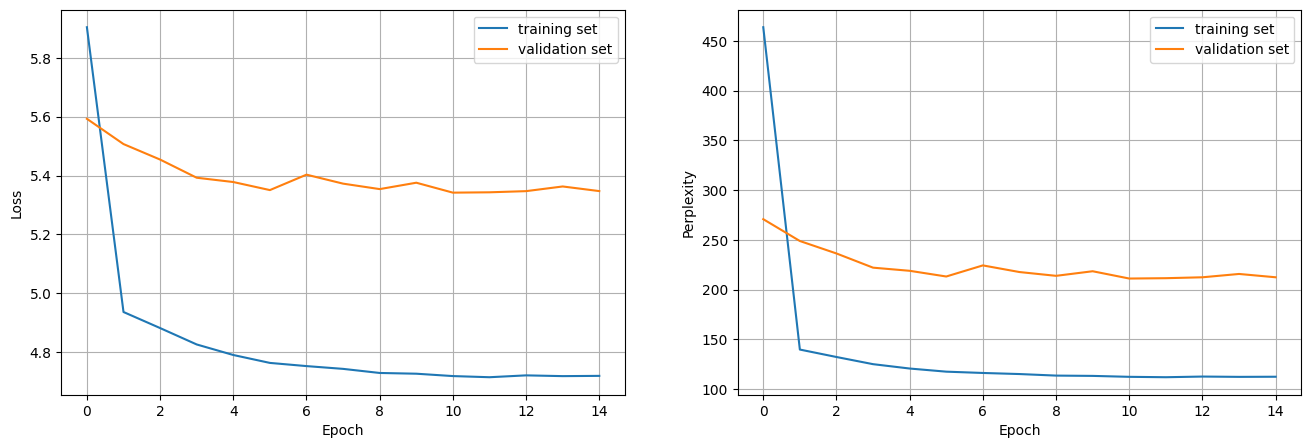

In [ ]:
# In this section we visualised the history of the training
def plot_training_history(training_info):
  fig, axs = plt.subplots(1, 2, figsize=(16, 5))
  axs[0].plot(training_info.history['loss'], label="training set") # The first plot demontrated the loss function changes
  axs[0].plot(training_info.history['val_loss'], label="validation set")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Loss")
  axs[0].grid(True)
  axs[0].legend()
  try:
    axs[1].plot(training_info.history['perplexity'], label="training set") # The second plot demonstrate the perplexity changes
    axs[1].plot(training_info.history['val_perplexity'], label="validation set")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Perplexity")
    axs[1].grid(True)
    axs[1].legend()
  except:
    pass
  plt.show()

plot_training_history(training_info)


In [ ]:
# Inspection for the testing result
test_loss, test_perplexity = model.evaluate(Xtest, ytest, verbose=0)
print("Test loss:", test_loss)
print("Test perplexity:", test_perplexity)


Test loss: 5.294443607330322
Test perplexity: 202.75033569335938


In [ ]:
# This section we conducted the implementation of the model in language autocompletion
from keras.preprocessing.sequence import pad_sequences
from scipy.stats import rv_discrete

# Assuming word_to_index and model are defined elsewhere and imported correctly
index_to_word = {i: w for w, i in word_to_index.items()}

seed_text = "<s> sun was shining and the sky was"
seq = [word_to_index[w] for w in seed_text.split()] #  This line transforms a string of text (seed_text) into a sequence of integers
padded_seq = pad_sequences([seq], maxlen=seqlen, padding='post') # Ensuring that all sequences fed into the neural network have the same length

# Generate words based on the model's prediction
for i in range(seqlen - len(seq)):
    full_prediction = model.predict(padded_seq, verbose=0) # Using the trained model to predict the next set of probabilities for the next word in the sequence
    next_word_prediction = full_prediction[0][len(seq) + i, :] # Selecting the probabilities corresponding to the position of the next word to be generated (len(seq) + i)
    dpd = rv_discrete(values=(list(range(len(next_word_prediction))), next_word_prediction)) # Creating a discrete random variable based on the predicted probabilities
    padded_seq[0][len(seq) + i] = dpd.rvs(size=1) # Updating the padded_seq at the position of the next word (len(seq) + i)

# Convert the indices back to words and prepare the output
sampled_words = [index_to_word.get(word_index, '<UNK>') for word_index in padded_seq[0]]
# Joining the newly generated words into a string, with the length of next two words
next_words_string = ' '.join(sampled_words[len(seq):len(seq)+2])


output_text = seed_text + ' ' + next_words_string
print(output_text)

<ipython-input-14-697ba1e37f8c>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  padded_seq[0][len(seq) + i] = dpd.rvs(size=1) # Updating the padded_seq at the position of the next word (len(seq) + i)


<s> sun was shining and the sky was the midst


**Result write-up**

We used the training history plot, testing perplexity and the model implementation, in three ways to demonstrate the model-1 performance. The plot on the left side demonstrates the training history that loss against the epochs. The training set loss significantly declined from 5.9 to 4.9 within 2 epochs. After that, the gradient of the line gradually decreased and finally settled around 4.7. The validation loss started at a relatively lower position than the training set, but it has an overall slower decline trend. It was also settled at 5.4 after 5 epochs. Overall, there was a continuous and stable gap about 0.6 loss difference between the training set and validation set. The perplexity plot on the right hand side also shows a similar trend. The perplexity of the training set significantly decreased from 450 to around 150 after the first epoch, and then started to gradually decrease; finally settled around 110 after 9 epochs. The perplexity of the validation set started around 270 and gently decreased to 220 after 5 epochs; after that, it was settled at this level. The differences in perplexity between the training and validation set were also stable, with about 100 units.

At the model evaluation phase, the testing perplexity was 202.75 and the testing loss was 5.29. In model implementation phase, the model generated the next two words of the given seed text by "sun was shinging and the sky" "was midst"

# **2. Model-2: Two-word autocompletion (method 2)**

The model-2 is my another approach solving the two-word autocompletion task. Because I was not sure that predicting multiple words one-by-one and export the first two words is satisfied the instruction or not. So I used a different method that can literally predict next two words in one shot. The basic structure of this model is same as the model-1, also RNN lanague model. However, in model-2 I split the corpus into multiple "two-word pair", coverted each word pair to indices by one-hot encoding, then used them to train the model. Although the output of model was still one index, but it could be translated into two words.

**Preparation of training material**

In [ ]:

# The similar code will not be explained
sentences = []
for s in text:
  lower_s = [word.lower() for word in s]
  padded_lower_s = list(pad_sequence(lower_s,
                                     n=2,
                                     pad_left=True,
                                     left_pad_symbol="<s>",
                                     pad_right=True,
                                     right_pad_symbol="</s>"))
  sentences.append(padded_lower_s)

# Setting the new function to split the sentence into the two-word pair
def split_into_word_pairs(text):
    words = text.split()
    return [' '.join(words[i:i+2]) for i in range(len(words) - 1)]

def process_sentences(sentences):
    pairs_list = [] # Building empty list
    for sentence in sentences:
        # Transferring the sentence to the string
        sentence_str = ' '.join(sentence)
        pairs = split_into_word_pairs(sentence_str) # Using the function defined before
        pairs_list.append(pairs)
    return pairs_list

cutted_sentences = process_sentences(sentences)

words = list(flatten(cutted_sentences))

# The function of vocabulary cannot be directly applied to the word pair, we need to define our own function
from collections import Counter
pair_counts = Counter(words) # Counting the frequency of all word pairs

# Building a vocab that only contain frequency > 3
unk_cutoff = 3
vocab = {pair for pair, count in pair_counts.items() if count >= unk_cutoff}

UNK = "<UNK>"
vocab.add("<UNK>") # But we still need to add the <UNK> into the vocab

vocab_index = {word: idx for idx, word in enumerate(vocab)} # Creating the mapping of vocab to index

# Inspection
print("Length of corpus:", len(words))
print("Length of vocabulary:", len(vocab))
print("Unique words in corpus:", len(set(words)))

# Partition into train and test
test_words = words[:10000]
train_words = words[10000:]

Length of corpus: 2021351
Length of vocabulary: 81246
Unique words in corpus: 388140


**Structuring the input & output data**

In [ ]:

# Function to convert word pairs to indices using the vocabulary index
def lookup_word(word, word_to_index, unk_index=0):
    return word_to_index.get(word, unk_index)

# Creating the mapping of word pair to index
word_to_index = {word: i for i, word in enumerate(vocab, start=1)}



# If the word pair is not in the list, return as unkown
def lookup_word(word, word_to_index, unk_index=0):
    return word_to_index.get(word, unk_index)


# Create a list of indices for training and testing sets using the lookup_word function
train_indices = [lookup_word(w, vocab_index, vocab_index[UNK]) for w in train_words]
test_indices = [lookup_word(w, vocab_index, vocab_index[UNK]) for w in test_words]


#Inspect
print(train_indices[:25])
print(test_indices[:25])

[11121, 48642, 57576, 55474, 77292, 77292, 77292, 32356, 56694, 77292, 15232, 44843, 69705, 55474, 32877, 40301, 58009, 77292, 77292, 19637, 48642, 28074, 12528, 2302, 77292]
[38811, 70178, 46842, 16478, 29489, 77292, 77292, 77883, 64296, 61873, 44135, 32737, 77292, 77292, 65605, 22234, 77292, 77292, 77292, 77292, 38136, 11852, 7134, 65945, 10407]


In [ ]:
# In this section we built a series of corresponding input & output arrays that have a word-difference about 2 words

seqlen = 32 # Words number for each array, considering the relatively small amount of sample size and more training arrays, we used a relatively smaller sequence length

# Similar function as model-1
def prepare_sequences(words, unk_index, seqlen=seqlen):
  trunc_length = len(words) % seqlen
  X = np.array(words)[trunc_length:].reshape((-1, seqlen))
  y = np.array(words + [unk_index])[trunc_length + 1:].reshape((-1, seqlen))
  return X, y

Xtrain, ytrain = prepare_sequences(train_indices, word_to_index["<UNK>"])
Xtest, ytest = prepare_sequences(test_indices, word_to_index["<UNK>"])

#Inspect
print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)

(62854, 32) (62854, 32)
(312, 32) (312, 32)


**Model building & training**

In [ ]:
# The function of model building is similar to the model-1 but with a few adjustment due to the changing of corpus

def perplexity(y_true, y_pred):
  cross_entropy = tf.losses.sparse_categorical_crossentropy(y_true, y_pred)
  perplexity = tf.exp(tf.reduce_mean(cross_entropy))
  return perplexity

def build_model(input_width=len(vocab), input_length=seqlen, output_width=len(vocab), learning_rate=0.1):
  model = Sequential()
  model.add(Embedding(input_dim=input_width, output_dim=64, input_length=seqlen))
  model.add(LSTM(32, return_sequences=True, activation='tanh'))
  model.add(LSTM(32, return_sequences=True, activation='tanh'))
  model.add(TimeDistributed(Dense(output_width, activation='softmax')))
  model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=[perplexity])
  return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 64)            5199744   
                                                                 
 lstm (LSTM)                 (None, 32, 32)            12416     
                                                                 
 lstm_1 (LSTM)               (None, 32, 32)            8320      
                                                                 
 time_distributed (TimeDist  (None, 32, 81246)         2681118   
 ributed)                                                        
                                                                 
Total params: 7901598 (30.14 MB)
Trainable params: 7901598 (30.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
training_info = model.fit(Xtrain,ytrain, batch_size=64, validation_split=0.10, epochs=30, callbacks=EarlyStopping(monitor="val_loss", patience=5))

Epoch 1/30
884/884 [==============================] - 92s 95ms/step - loss: 8.2547 - perplexity: 6498.4824 - val_loss: 7.5743 - val_perplexity: 2029.7856
Epoch 2/30
884/884 [==============================] - 69s 78ms/step - loss: 7.3078 - perplexity: 1506.7030 - val_loss: 7.3660 - val_perplexity: 1639.0502
Epoch 3/30
884/884 [==============================] - 63s 71ms/step - loss: 7.0398 - perplexity: 1149.5248 - val_loss: 7.2730 - val_perplexity: 1488.4973
Epoch 4/30
884/884 [==============================] - 65s 74ms/step - loss: 6.8636 - perplexity: 964.2480 - val_loss: 7.1772 - val_perplexity: 1349.8529
Epoch 5/30
884/884 [==============================] - 65s 73ms/step - loss: 6.7229 - perplexity: 836.5618 - val_loss: 7.1603 - val_perplexity: 1324.3887
Epoch 6/30
884/884 [==============================] - 66s 74ms/step - loss: 6.6227 - perplexity: 757.0536 - val_loss: 7.1211 - val_perplexity: 1273.4735
Epoch 7/30
884/884 [==============================] - 63s 72ms/step - loss: 6.5

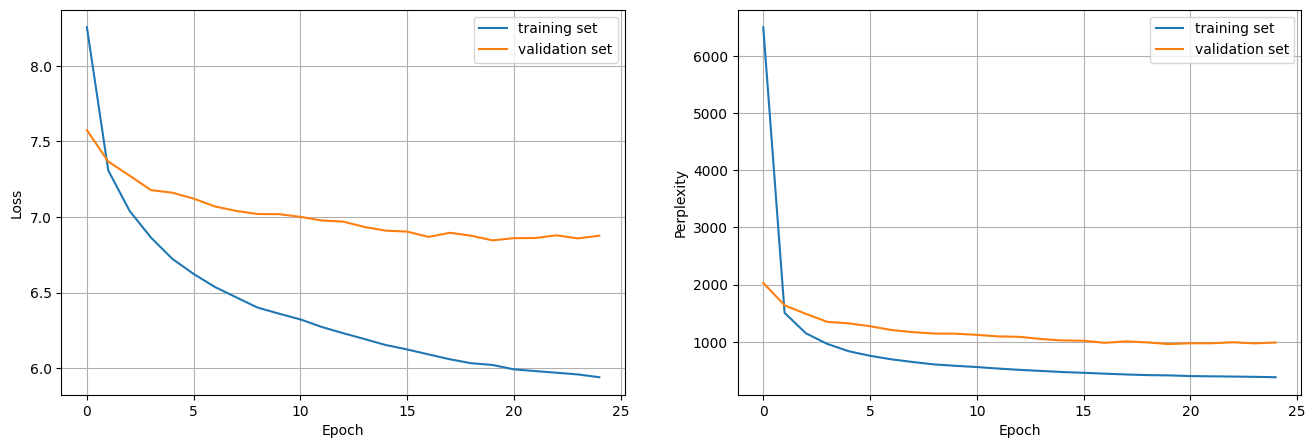

In [ ]:
def plot_training_history(training_info):
  fig, axs = plt.subplots(1, 2, figsize=(16, 5))
  axs[0].plot(training_info.history['loss'], label="training set") # The first plot demontrated the loss function changes
  axs[0].plot(training_info.history['val_loss'], label="validation set")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Loss")
  axs[0].grid(True)
  axs[0].legend()
  try:
    axs[1].plot(training_info.history['perplexity'], label="training set") # The second plot demonstrate the perplexity changes
    axs[1].plot(training_info.history['val_perplexity'], label="validation set")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Perplexity")
    axs[1].grid(True)
    axs[1].legend()
  except:
    pass
  plt.show()

plot_training_history(training_info)

In [ ]:
# Inspection for the testing result
test_loss, test_perplexity = model.evaluate(Xtest, ytest, verbose=0)
print("Test loss:", test_loss)
print("Test perplexity:", test_perplexity)


Test loss: 6.726602554321289
Test perplexity: 841.1021728515625


In [ ]:
# The procedure of actual implementation of model-2 was slightly different to the model-1
from keras.preprocessing.sequence import pad_sequences
from scipy.stats import rv_discrete

index_to_word = {i: w for w, i in word_to_index.items()}

seed_text = "sun is shining, the sky is"
token_list = [token for token in split_into_word_pairs(seed_text)] # We need to use the pre-defined model to split the seed_text to the word pair
seq = [word_to_index.get(token, word_to_index[UNK]) for token in token_list] # Transform them into indices and stored
seqlen = 32
padded_seq = pad_sequences([seq], maxlen=seqlen, padding='post', truncating='post')
# If seq is shorter than 32, padding will be added at the end (padding='post'); if it's longer, it will be truncated at the end (truncating='post')

# Model prediction and sampling new words, the core idea is similar to the model-1, but each token at here was a word pair
for i in range(seqlen - len(seq)): # The procedure will keep going till the length of seq achieved
    full_prediction = model.predict(padded_seq, verbose=0)
    next_word_probs = full_prediction[0][len(seq) + i, :]
    dpd = rv_discrete(values=(range(len(next_word_probs)), next_word_probs))
    next_index = dpd.rvs(size=1)
    padded_seq[0][len(seq) + i] = next_index

# Print word sequence
sampled_words = [index_to_word[idx] if idx in index_to_word else UNK for idx in padded_seq[0]] # Collect the result of generation
print(' '.join([seed_text] + sampled_words[len(token_list):len(token_list)+1]))

<ipython-input-15-cda751842517>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  padded_seq[0][len(seq) + i] = next_index


sun is shining, the sky is the tangle


**Result write-up**

We used the training history plot, testing perplexity and the model implementation, in three ways to demonstrate model-3 performance. The plot on the left side demonstrates the training history that loss against the epochs. The training set loss significantly declined from 8.2 to 7.3 within 2 epochs. After that, the gradient of the line continuously decreased and achieved the level of 6.0 after 25 epochs. The validation loss started at a relatively lower position than the training set, which is about 7.5, but it has an overall slower decline trend. It decreased by 0.6 within 25 epochs and settled at about 6.9 at the end of training. Overall, the loss difference gap between the training set and validation set was getting greater due to the faster-declining speed of the training set. The perplexity plot on the right hand side also shows a similar trend. The perplexity of the training set significantly decreased from 6500 to around 1500 after 2 epochs, and then started to gradually decrease; the training perplexity spent next 23 epochs decreased from 1500 to 500 units. The perplexity of the validation set started around 2000 and gently decreased to 1000 after 15 epochs; after that, it was settled at this level. The differences in perplexity between the training and validation set were also stable, with about 500 units.

At the model evaluation phase, the testing perplexity was 841.10 and the testing loss was 6.73. In the model implementation phase, the model's performance was surprisingly good (might be the chance), it generated the next two words of the given seed text by "sun is shining and the sky is" "the tangle"


# **3. The Model-3: Two-letter autocompletion**

Model-3 is the approach solving the two-letter autocompletion task, its structure is basically the same with model-1 and model-2, and the core idea of preparation is closer to the model-2. Model-3 further split each word in the corpus into multiple "two-letter pair", and turning these letter-pairs into the one-hot encoding. Based on that, we can run the RNN again and finish the prediction.The prediction output was still one index but can be translated to two letters.

**preparation of training material**

In [ ]:
# In this section, we used the corpus again

# The first step to do is to split all the words, but this time split into letter pairs
def split_into_pairs(text):
    return [text[i:i+2] for i in range(len(text) - 1)]

# Similar logic as model-2
def process_sentences(sentences):
    pairs_list = []
    for sentence in sentences:
        sentence_str = ' '.join(sentence)
        pairs = split_into_pairs(sentence_str)
        pairs_list.append(pairs)
    return pairs_list

sentences = []
for s in text:
  lower_s = [word.lower() for word in s]
  padded_lower_s = list(pad_sequence(lower_s,
                                     n=2,
                                     pad_left=True,
                                     left_pad_symbol="<s>",
                                     pad_right=True,
                                     right_pad_symbol="</s>"))
  sentences.append(padded_lower_s)

# Inspect
for s in sentences[:5]:
  print(s)

cutted_sentences = process_sentences(sentences)

# Inspection
print(cutted_sentences[:3])

['<s>', '[', 'the', 'man', 'who', 'was', 'thursday', 'by', 'g', '.', 'k', '.', 'chesterton', '1908', ']', '</s>']
['<s>', 'to', 'edmund', 'clerihew', 'bentley', '</s>']
['<s>', 'a', 'cloud', 'was', 'on', 'the', 'mind', 'of', 'men', ',', 'and', 'wailing', 'went', 'the', 'weather', ',', 'yea', ',', 'a', 'sick', 'cloud', 'upon', 'the', 'soul', 'when', 'we', 'were', 'boys', 'together', '.', '</s>']
['<s>', 'science', 'announced', 'nonentity', 'and', 'art', 'admired', 'decay', ';', 'the', 'world', 'was', 'old', 'and', 'ended', ':', 'but', 'you', 'and', 'i', 'were', 'gay', ';', 'round', 'us', 'in', 'antic', 'order', 'their', 'crippled', 'vices', 'came', '--', 'lust', 'that', 'had', 'lost', 'its', 'laughter', ',', 'fear', 'that', 'had', 'lost', 'its', 'shame', '.', '</s>']
['<s>', 'like', 'the', 'white', 'lock', 'of', 'whistler', ',', 'that', 'lit', 'our', 'aimless', 'gloom', ',', 'men', 'showed', 'their', 'own', 'white', 'feather', 'as', 'proudly', 'as', 'a', 'plume', '.', '</s>']
[['<s', 's

In [ ]:
words = list(flatten(cutted_sentences))
vocab = Vocabulary(words, unk_cutoff=5) # The unk_cut off need to be adjusted according to the vocabulary and the number of prosible combination of letter pair
print("Length of corpus:", len(words))
print("Length of vocabulary:", len(vocab))
print("Unique words in corpus:", len(set(words)))


# Partition into train and test
test_words = words[:20000]
train_words = words[20000:]
print(words[:5])

Length of corpus: 9421245
Length of vocabulary: 799
Unique words in corpus: 941
['<s', 's>', '> ', ' [', '[ ']


**Structuring the input & output data**

In [ ]:
# In this section, mapping the word into index

word_to_index = {w: i for i, w in enumerate(vocab)}

train_indices = [word_to_index[vocab.lookup(w)] for w in train_words]
test_indices = [word_to_index[vocab.lookup(w)] for w in test_words]

#Inspect
print(train_indices[:25])
print(test_indices[:25])

[5, 6, 7, 40, 106, 8, 145, 182, 19, 94, 143, 75, 21, 93, 192, 193, 106, 130, 114, 261, 75, 150, 19, 77, 135]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 13, 17, 18, 19, 5, 6, 20, 21]


In [ ]:
# In this section we built a series of corresponding input & output arrays that have a word-difference about 2 words

seqlen = 64
# Because this time, the token was letter pair, so the sequence length need to be increased

def prepare_sequences(words, unk_index, seqlen=seqlen):
  trunc_length = len(words) % seqlen
  X = np.array(words)[trunc_length:].reshape((-1, seqlen))
  y = np.array(words + [unk_index])[trunc_length + 1:].reshape((-1, seqlen))
  return X, y

Xtrain, ytrain = prepare_sequences(train_indices, word_to_index["<UNK>"])
Xtest, ytest = prepare_sequences(test_indices, word_to_index["<UNK>"])

#Inspect
print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)

(146894, 64) (146894, 64)
(312, 64) (312, 64)


**Model building & training**

In [ ]:
# Similar procedure as model-1, model-2

def perplexity(y_true, y_pred):
  cross_entropy = tf.losses.sparse_categorical_crossentropy(y_true, y_pred)
  perplexity = tf.exp(tf.reduce_mean(cross_entropy))
  return perplexity

def build_model(input_width=len(vocab), input_length=seqlen, output_width=len(vocab), learning_rate=0.1):
  model = Sequential()
  model.add(Embedding(input_dim=input_width, output_dim=64, input_length=input_length))
  model.add(LSTM(32, return_sequences=True, activation='tanh'))
  model.add(LSTM(32, return_sequences=True, activation='tanh'))
  model.add(TimeDistributed(Dense(output_width, activation='softmax')))
  model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=[perplexity])
  return model

model = build_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 64, 64)            51136     
                                                                 
 lstm_13 (LSTM)              (None, 64, 32)            12416     
                                                                 
 lstm_14 (LSTM)              (None, 64, 32)            8320      
                                                                 
 time_distributed_6 (TimeDi  (None, 64, 799)           26367     
 stributed)                                                      
                                                                 
Total params: 98239 (383.75 KB)
Trainable params: 98239 (383.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
training_info = model.fit(Xtrain,ytrain, batch_size=128, validation_split=0.10, epochs=10, callbacks=EarlyStopping(monitor="val_loss", patience=5))

Epoch 1/10
1033/1033 [==============================] - 496s 471ms/step - loss: 1.8433 - perplexity: 10.4869 - val_loss: 1.8779 - val_perplexity: 6.5822
Epoch 2/10
1033/1033 [==============================] - 479s 463ms/step - loss: 1.5968 - perplexity: 4.9402 - val_loss: 1.8168 - val_perplexity: 6.1917
Epoch 3/10
1033/1033 [==============================] - 480s 465ms/step - loss: 1.5824 - perplexity: 4.8686 - val_loss: 1.7845 - val_perplexity: 5.9974
Epoch 4/10
1033/1033 [==============================] - 480s 465ms/step - loss: 1.5997 - perplexity: 4.9551 - val_loss: 1.8097 - val_perplexity: 6.1505
Epoch 5/10
1033/1033 [==============================] - 479s 464ms/step - loss: 1.6031 - perplexity: 4.9708 - val_loss: 1.7900 - val_perplexity: 6.0296
Epoch 6/10
1033/1033 [==============================] - 477s 462ms/step - loss: 1.6024 - perplexity: 4.9684 - val_loss: 1.8159 - val_perplexity: 6.1861
Epoch 7/10
1033/1033 [==============================] - 480s 465ms/step - loss: 1.6087 

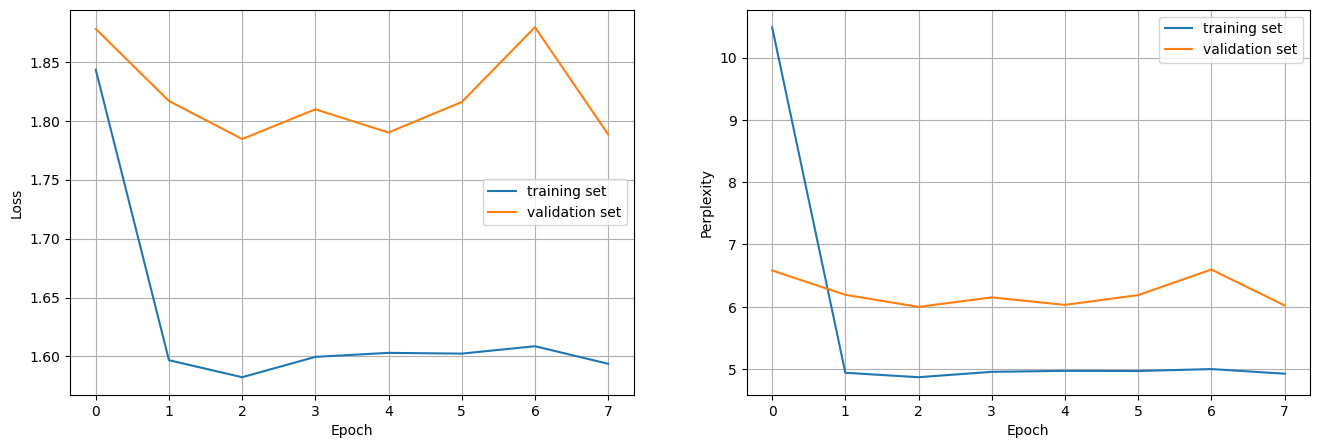

Test loss: 1.7557342052459717
Test perplexity: 5.788415431976318


In [ ]:
plot_training_history(training_info)

test_loss, test_perplexity = model.evaluate(Xtest, ytest, verbose=0)
print("Test loss:", test_loss)
print("Test perplexity:", test_perplexity)

In [ ]:
# The implementation logic at here was similar to the model-2

index_to_word = {i: w for w, i in word_to_index.items()}


seed_text = "merry chrism"
token_list = []
for token in split_into_pairs(seed_text):
  token_list.append(token)
seq = [word_to_index[token] for token in token_list]
padded_seq = pad_sequences([seq], maxlen=seqlen, padding='post')


# Sample word sequence
for i in range(seqlen - len(seq)):
  full_prediction = model.predict(padded_seq, verbose=0)
  next_word_prediction = full_prediction[0][len(seq) + i, :]
  dpd = rv_discrete(values=(list(range(len(next_word_prediction))), next_word_prediction))
  padded_seq[0][len(seq) + i] = dpd.rvs(size=1)


# Print word sequence
sampled_words = []
for word_index in padded_seq[0]:
  sampled_words.append(index_to_word[word_index])
print(seed_text + sampled_words[len(token_list)])


<ipython-input-49-16adac6b7a71>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  padded_seq[0][len(seq) + i] = dpd.rvs(size=1)


merry chrismfe


**Result write-up**

We still used the training history plot, testing perplexity and the model implementation, in three ways to demonstrate the model-3 performance. Compared to the previous 2 models, model-3 had a significantly smaller starting point for both loss and perplexity history. Due to the fewer possible combinations in two-letter pairs, which used the same corpus but only had 799 vocabulary. The plot on the left side demonstrates the training history that loss against the epochs. The training set loss declined from 1.85 to 1.6 after 1 epoch. After that, the training loss was stopped at 1.6. The validation loss didn't have a clearly downward trending but kept fluctuating between 1.8 and 1.9. Overall, there was an approximated gap about 0.2 loss difference between the training set and the validation set. The perplexity plot on the right hand side also shows a similar trend. The perplexity of the training set firstly significantly decreased from 1 to 5 after the first epoch and then was almost fixed at a level of 5. The perplexity of the validation set was also fluctuating between 6 and 7 across all epochs. The differences in perplexity between the training and validation set were also stable, with about 1 unit.

At the model evaluation phase, the testing perplexity was 5.79 and the testing loss was 1.76. In the model implementation phase, the model completes the next two words of the given seed text by "merry chrism" "fe".


# **4. Evaluation**

This section reveals several critical insights and potential shortcomings in the methodology used. Firstly, the selection of the data corpus combined by novels from before the 21st century, raises concerns regarding the relevance and applicability of the learned language patterns to contemporary English usage. The limited diversity of the corpus, sourced from just ten novels on Gutenberg, further exacerbates this issue. Notably, the inclusion of multiple works by a single author such as Shakespeare may skew the language model towards specific stylistic and lexical preferences, thereby limiting its generalisability.

In terms of model complexity and the size of the corpus, the paper hints at a possible mismatch that could adversely affect the model's performance. Utilizing a highly complex model on a relatively small dataset may lead to overfitting, where the model learns specific details and noise in the training data to the extent that it performs poorly on new, unseen data, which is obviously discovered in model-2. Conversely, a too simplistic model might fail to capture necessary linguistic nuances, thus underperforming despite the larger volume of data. The balance between model complexity and data size is crucial and appears to be not so ideal in the current project, our corpus size was too small to have a better performance.

Moreover, the evaluation criteria based on perplexity alone seem insufficient to capture the model's effectiveness comprehensively. For instance, while Model-3 showed the best results according to perplexity metrics, it was Model-2—with the worst perplexity performance—that produced the most reasonable predictions in practical implementations. Although model-3 using two-letter prediction achieved the best results in terms of data results, it may not have the best performance in terms of actual implementation, instead, the actual implementation of model-2, which had the worst data performance, came out with the most reasonable vocabulary. So I suspect that we can't exactly use perplexity to evaluate everything about a model. We can see this from the fact that the same corpus has very significantly different vocab sizes, with model-2 having even a hundred times the size of model-3's vocab. Smaller vocab makes for smaller perplexity, but they don't necessarily always result in better performance. As the length of each token gets larger, it seems more likely to learn syntax and syntax-related content, as there is more information embedded in the token.

# **Reference:**

Bengio, Y., Simard, P., & Frasconi, P. (1994). Learning long-term dependencies with gradient descent is difficult. IEEE Transactions on Neural Networks, 5(2), 157-166.

Cho, K., Van Merriënboer, B., Gulcehre, C., Bahdanau, D., Bougares, F., Schwenk, H., & Bengio, Y. (2014). Learning phrase representations using RNN encoder-decoder for statistical machine translation. arXiv preprint arXiv:1406.1078.

Elman, J. L. (1990). Finding structure in time. Cognitive Science, 14(2), 179-211.

Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural Computation, 9(8), 1735-1780.

Jozefowicz, R., Zaremba, W., & Sutskever, I. (2015). An empirical exploration of recurrent network architectures. In Proceedings of the 32nd International Conference on Machine Learning (ICML-15) (pp. 2342-2350).
